# Disjoint parameter spaces

Importance sampling in practice is made difficult when two models have only partial overlap in their parameter space. In the real world this happens all the time -- Planck has different nuisance parameters than DES, for instance.

In this notebook we will consider two distributions that partially overlap: $P_1(x,y)$ and $P_2(y,z)$. We will make the simplifying assumption that both are Gaussian, sample them, build `resampler` objects for both, and compute the joint distribution.

In [1]:
#Import things
import numpy as np
import matplotlib.pyplot as plt
import resampler as samp
import scipy.stats
import corner, emcee
import chainconsumer as CC
%matplotlib inline

In [2]:
#Plot formatting
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
#Gaussian 1
means = np.array([0.0, 3.0])
stddevs = np.array([1.0, 0.1]) #standard deviations
rho = -0.999 #correlation
cov = np.array([[stddevs[0]**2, rho*stddevs[0]*stddevs[1]],
                [rho*stddevs[0]*stddevs[1], stddevs[1]]])
icov = np.linalg.inv(cov)

In [4]:
#Draw samples and compute the log liklihoods
N_samples = 100000
chain = np.random.multivariate_normal(mean=means, cov=cov, size=N_samples)
lnlikes = np.log(scipy.stats.multivariate_normal.pdf(chain, mean=means, cov=cov))

In [5]:
#Create the ImportanceSampler object for this chain
RS = samp.resampler(chain, lnlikes, scale=8)
RS.select_training_points(200, method="LH")
RS.train()

      fun: 548.7302553143788
 hess_inv: array([[9.77958145e-05]])
      jac: array([0.36193848])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 160
      nit: 9
     njev: 144
   status: 2
  success: False
        x: array([2.53078739])


In [6]:
#Gaussian 2
means2 = np.array([4.0, -2.0])
stddevs2 = np.array([0.3, 0.4]) #standard deviations
rho2 = 0.9 #correlation
cov2 = np.array([[stddevs2[0]**2, rho2*stddevs2[0]*stddevs2[1]],
                [rho2*stddevs2[0]*stddevs2[1], stddevs2[1]]])
icov2 = np.linalg.inv(cov2)

In [7]:
#Samples from the second Gaussian
chain2 = np.random.multivariate_normal(mean=means2, cov=cov2, size=N_samples)
lnlikes2 = np.log(scipy.stats.multivariate_normal.pdf(chain2, mean=means2, cov=cov2))

In [8]:
#Create an ImportanceSampler for the second Gaussian
RS2 = samp.resampler(chain2, lnlikes2, scale=8)
RS2.select_training_points(200, method="LH")
RS2.train()

      fun: 502.6682915201934
 hess_inv: array([[7.40134475e-07]])
      jac: array([-0.0255127])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 44
      nit: 8
     njev: 33
   status: 2
  success: False
        x: array([2.52336125])


In [9]:
#Sample from the combined lnlikelihood
def log_likelihood_combined(params):
    x,y,z = params
    return RS.predict(np.atleast_2d([x,y])) + RS2.predict(np.atleast_2d([y,z]))

initial = np.array([0, 3, -3])
ndim, nwalkers = len(initial), 100
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_combined)
print("Running first burn-in")
p0 = initial + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 5000);

Running first burn-in
Running second burn-in
Running production...


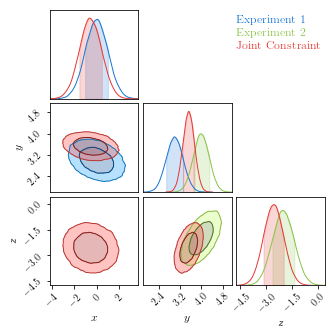

In [10]:
testchain = sampler.flatchain

c = CC.ChainConsumer()
c.add_chain(chain, parameters=["$x$", "$y$"], name="Experiment 1")
c.add_chain(chain2, parameters=["$y$","$z$"], name="Experiment 2")
c.add_chain(testchain, parameters=["$x$", "$y$","$z$"], name="Joint Constraint")

fig = c.plotter.plot()
#fig.savefig("joint_distribution_example.png", dpi=300, bbox_inches="tight")
#fig.savefig("joint_distribution_example.pdf", dpi=300, bbox_inches="tight")

In [11]:
#Sample from the true combined lnlikelihood
def true_log_likelihood_combined(params):
    x,y,z = params
    D1 = means - params[:2] #x,y; for likelihood 1
    D2 = means2 - params[1:] #y,z; for likelihood 2
    return -0.5*(np.dot(D1, np.linalg.solve(cov, D1)) + np.dot(D2, np.linalg.solve(cov2, D2)))

initial = np.array([0, 3, -3])
ndim, nwalkers = len(initial), 100
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_combined)
print("Running first burn-in")
p0 = initial + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler2.run_mcmc(p0, 1000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler2.run_mcmc(p0, 1000)
sampler2.reset()
print("Running production...")
sampler2.run_mcmc(p0, 5000);

Running first burn-in
Running second burn-in
Running production...


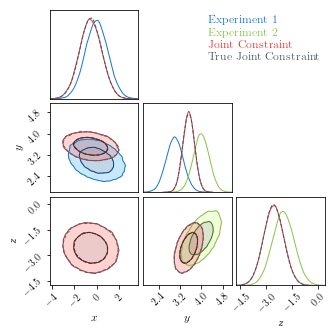

In [13]:
testchain2 = sampler2.flatchain

c = CC.ChainConsumer()
c.add_chain(chain, parameters=["$x$", "$y$"], name="Experiment 1")
c.add_chain(chain2, parameters=["$y$","$z$"], name="Experiment 2")
c.add_chain(testchain, parameters=["$x$", "$y$","$z$"], name="Joint Constraint")
c.add_chain(testchain2, parameters=["$x$", "$y$","$z$"], name="True Joint Constraint", 
            linestyle='--', color='#455A64')

c.configure(shade=[True, True, True, False])


fig = c.plotter.plot()
#fig.savefig("joint_distribution_example.png", dpi=300, bbox_inches="tight")
fig.savefig("joint_distribution_example.pdf", dpi=300, bbox_inches="tight")